In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, InputLayer, Conv2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization, Activation, ReLU, Flatten, Dense, Add, Dropout
from tensorflow.keras.optimizers import  Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from PIL import Image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from tensorflow.keras.applications import VGG16, MobileNetV2, DenseNet201


In [ ]:
# Tentukan direktori dataset
train_dir = '/content/drive/MyDrive/SKRIPSI/Dataset tanpa augment/train'
val_dir = '/content/drive/MyDrive/SKRIPSI/Dataset tanpa augment/valid'
test_dir = '/content/drive/MyDrive/SKRIPSI/Dataset tanpa augment/test'

In [ ]:
# Data generator dengan augmentasi untuk training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=14,             # Rotasi dari -14 hingga 14 derajat
)

# Data generator tanpa augmentasi untuk validation dan test set
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load data training
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load data validasi
validation_data = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load data test
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2026 images belonging to 4 classes.
Found 435 images belonging to 4 classes.
Found 433 images belonging to 4 classes.


In [ ]:
def densenet201_Model():
    inputs = Input(shape=(224, 224, 3))
    base_model = DenseNet201(include_top=False, weights="imagenet", input_tensor=inputs)

    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Use gradient clipping
    optimizer = Adam(learning_rate=1e-5, clipvalue=1.0)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Initialize model
model = densenet201_Model()
model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 20,297,284 (77.43 MB)

 Trainable params: 20,066,180 (76.55 MB)

 Non-trainable params: 231,104 (902.75 KB)

In [ ]:
# Path untuk menyimpan model terbaik
checkpoint_path = '/content/drive/MyDrive/SKRIPSI/densenetepoch8.keras'

# Callback untuk menyimpan model terbaik
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Callback untuk early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    verbose=1
)

callbacks_list = [checkpoint, early_stopping]


In [ ]:
# Melatih model
epochs = 8

history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=epochs,
    callbacks=callbacks_list,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size
)


Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 45s/step - accuracy: 0.3976 - loss: 1.7263 
Epoch 1: val_accuracy improved from -inf to 0.60577, saving model to /content/drive/MyDrive/SKRIPSI/densenetepoch8.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 3232s 48s/step - accuracy: 0.3997 - loss: 1.7199 - val_accuracy: 0.6058 - val_loss: 0.9780
Epoch 2/8
 1/63 ━━━━━━━━━━━━━━━━━━━━ 52:36 51s/step - accuracy: 0.8125 - loss: 0.4973

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.60577 to 0.63158, saving model to /content/drive/MyDrive/SKRIPSI/densenetepoch8.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 207ms/step - accuracy: 0.8125 - loss: 0.4973 - val_accuracy: 0.6316 - val_loss: 0.9163
Epoch 3/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.7823 - loss: 0.5498 
Epoch 3: val_accuracy improved from 0.63158 to 0.78606, saving model to /content/drive/MyDrive/SKRIPSI/densenetepoch8.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 2872s 45s/step - accuracy: 0.7829 - loss: 0.5485 - val_accuracy: 0.7861 - val_loss: 0.6601
Epoch 4/8
 1/63 ━━━━━━━━━━━━━━━━━━━━ 45:52 44s/step - accuracy: 0.8125 - loss: 0.4495
Epoch 4: val_accuracy improved from 0.78606 to 0.78947, saving model to /content/drive/MyDrive/SKRIPSI/densenetepoch8.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 90s 736ms/step - accuracy: 0.8125 - loss: 0.4495 - val_accuracy: 0.7895 - val_loss: 0.6116
Epoch 5/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.9204 - loss: 0.2501 
Epoch 5: val_accura

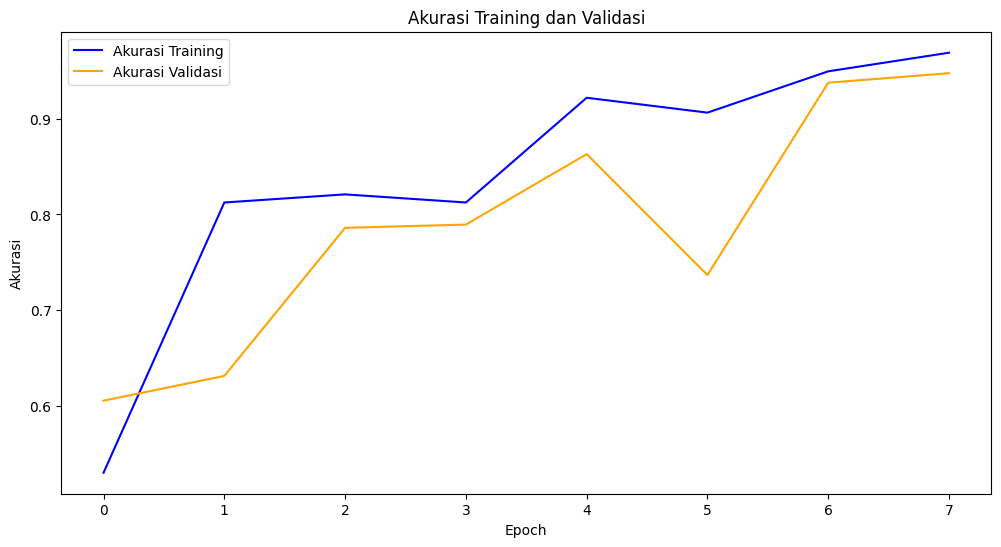

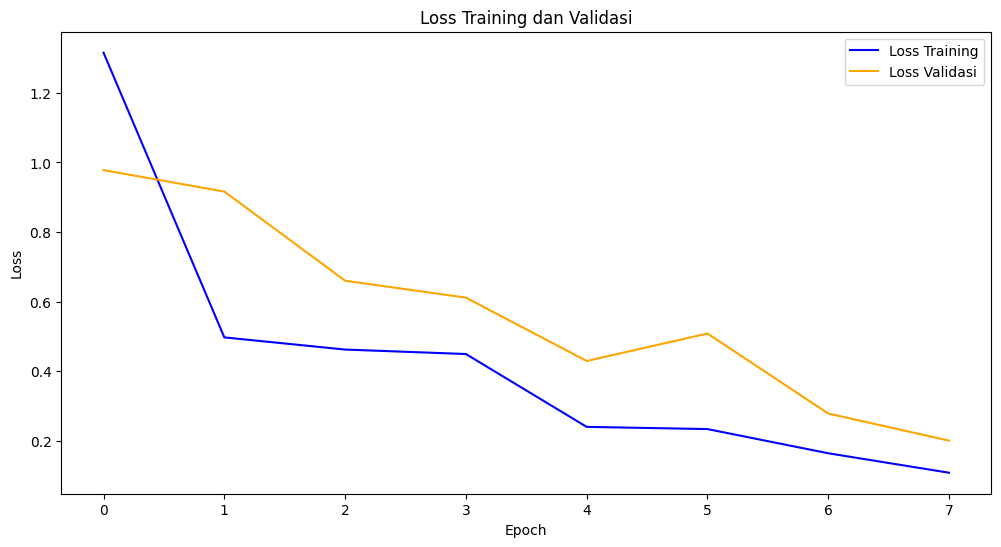

In [ ]:
# Plot akurasi
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Akurasi Training', color='blue')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi', color='orange')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss Training', color='blue')
plt.plot(history.history['val_loss'], label='Loss Validasi', color='orange')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Load model terbaik
model.load_weights(checkpoint_path)

# Evaluasi pada data test
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.9462 - loss: 0.2132
Test Loss: 0.3181697130203247
Test Accuracy: 0.9006928205490112


In [ ]:
# Prediksi pada data test
test_data.reset()  # Reset generator
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Label sebenarnya
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Laporan klasifikasi
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

14/14 ━━━━━━━━━━━━━━━━━━━━ 146s 10s/step
Classification Report:
              precision    recall  f1-score   support

   Anorganik       0.85      0.94      0.89       141
          B3       0.88      1.00      0.93        71
     Organik       0.95      0.98      0.96       108
      Residu       0.96      0.72      0.82       113

    accuracy                           0.90       433
   macro avg       0.91      0.91      0.90       433
weighted avg       0.91      0.90      0.90       433



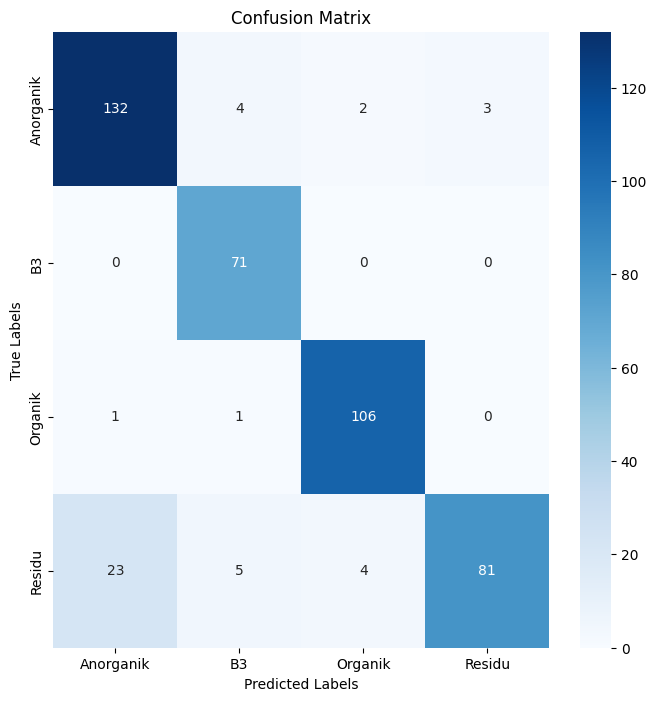

In [ ]:
# Menghitung confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
# Save the model to your Google Drive
model.save('/content/drive/MyDrive/SKRIPSI/densenet201_1st.h5')

In [ ]:
# Fungsi untuk mengunduh file model
from google.colab import files

def download_model(file_path=None):
    if not file_path:
        file_path = checkpoint_path  # Gunakan path default jika tidak diberikan
    print(f"Mengunduh file model dari: {file_path}")
    files.download(file_path)

# Contoh penggunaan
# Setelah pelatihan selesai, unduh model
download_model()  # Menggunakan checkpoint_path

Mengunduh file model dari: /content/drive/MyDrive/SKRIPSI/densenetepoch8.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# prompt: save the tflite model to drive
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to your Google Drive
with open('/content/drive/MyDrive/SKRIPSI/densenet201.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpjnul_eoz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139163561905840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139163556374912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139163556371392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139163556370336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139163556372096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139163520386848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139163520385968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139163524955504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139163520386144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139163524952864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13916352039265